# Example of using the pattern memberships for custom Gene Set Enrichment
- This notebook shows the combination of FlowSets with other downstream analyses.
- While there is an overrepresentation analysis custom build for sets with partial memberships, also other methods could be considered.
- It is shown how to extract the membership list for a pattern and how to apply a overrepresentation analysis on the list.

---
Author: Felix Offensperger

centers [-2, -1, 0, 1, 2]
Creating Universe Range -14.0 -> 6.0 with step size 0.01


/home/o/offensperger/.local/lib/python3.12/site-packages/flowsets/flowsets.py:661: RuntimeWarning: invalid value encountered in divide
  values = fuzz.trimf(self.universe, abc)/unscaledValues


Mean Expr log2FoldChange col 1
Expr Count cell_expr col 8
SD None col None
Cluster comparison col 6
Combining over state:  False
to_homogeneous: MSN24.KO vs Wildtype
to_homogeneous: HSF1.KD vs Wildtype
to_homogeneous: Double.KDKO vs Wildtype


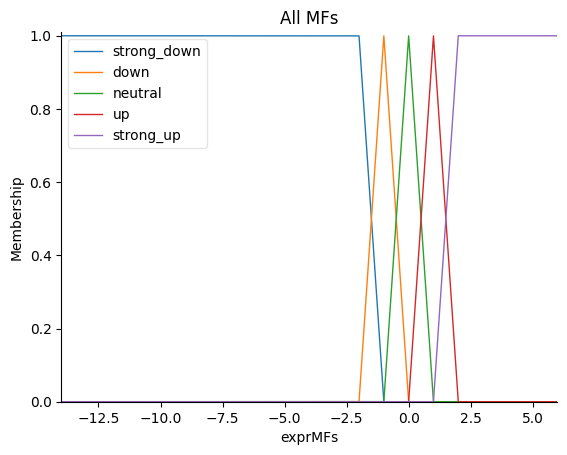

In [1]:
# We do the same FlowSets as in the Flowsets_example.ipynb
import os, sys, polars as pl
from flowsets import *

# Explicitly specify the schema for the columns
schema = {
    "baseMean": pl.Float32,
    "log2FoldChange": pl.Float32,
    "lfcSE": pl.Float32,
    "stat": pl.Float32,
    "pvalue": pl.Float32,
    "padj": pl.Float32,
    "comparison": pl.Utf8,
    "gene_id": pl.Utf8
}

# Read the cleaned results
deseq_results = pl.read_csv(
    './data/deseq2_results_37deg_10min_all_comparisons.csv',
    null_values=['NA'],
    schema=schema
)
deseq_results = deseq_results.with_columns(
    pl.col("log2FoldChange").fill_null(0),
    pl.col("padj").fill_null(1),
)
# Fuzzify the log2FoldChange values for each gene and comparison
explDFWide, mfFuzzy = LegacyFuzzifier.fuzzify(
    deseq_results, stepsize=0.01,
    symbol_column="gene_id", meancolName="log2FoldChange", sdcolName=None, exprcolName=None, clusterColName="comparison",
    mfLevels = ["strong_down","down","neutral","up", "strong_up"], centers=[-2, -1, 0, 1, 2],
    
)
# Create a FlowAnalysis object for the fuzzified data
# Define the mapping from comparison names to display names and order
series2name=(
       ("HSF1.KD vs Wildtype",'KO1 vs WT'),
        ("Double.KDKO vs Wildtype",'KO1+2 vs WT'),
       ("MSN24.KO vs Wildtype",'KO2 vs WT')
    )

fa= FlowAnalysis(explDFWide,"gene_id", series2name, mfFuzzy) 

Loading pathways from ./data/goslim.gmt
Identified 98 pathways
Calculating p-values for groups [1, 2, 3, 4, 10, 50, 100]


,pwid,pwname,pwFlow,pwGenes,allPwFlow,allPwGenes,pw_gene_intersection,pw_coverage,genes_coverage,mean_coverage,pw_coverage_zscore,pw_coverage_pval,pw_coverage_adj_pval
54,protein_folding,protein_folding,3.676439,21,204.590267,1058.000001,21,0.175069,0.017970,0.003146,4.842491,6.411060e-07,0.000063
71,response_to_heat,response_to_heat,1.289424,9,204.590267,1058.000001,9,0.143269,0.006302,0.000903,2.274471,1.146885e-02,0.470929
61,proteolysis_involved_in_cellular_protein_catab...,proteolysis_involved_in_cellular_protein_catab...,3.499561,57,204.590267,1058.000001,57,0.061396,0.017105,0.001050,2.185771,1.441619e-02,0.470929
68,regulation_of_transport,regulation_of_transport,1.344375,14,204.590267,1058.000001,14,0.096027,0.006571,0.000631,2.036272,2.086150e-02,0.511107
32,meiotic_cell_cycle,meiotic_cell_cycle,3.328095,37,204.590267,1058.000001,37,0.089949,0.016267,0.001463,1.820476,3.434329e-02,0.673128
62,pseudohyphal_growth,pseudohyphal_growth,1.523366,18,204.590267,1058.000001,18,0.084631,0.007446,0.000630,1.631703,5.137106e-02,0.839061
34,membrane_invagination,membrane_invagination,0.974079,13,204.590267,1058.000001,13,0.074929,0.004761,0.000357,1.287243,9.900474e-02,0.936977
79,RNA_catabolic_process,RNA_catabolic_process,1.525894,21,204.590267,1058.000001,21,0.072662,0.007458,0.000542,1.206738,1.137665e-01,0.936977
27,histone_modification,histone_modification,2.229515,31,204.590267,1058.000001,31,0.071920,0.010897,0.000784,1.180403,1.189199e-01,0.936977
65,regulation_of_organelle_organization,regulation_of_organelle_organization,2.656376,53,204.590267,1058.000001,53,0.050120,0.012984,0.000651,1.178077,1.193829e-01,0.936977


Index(['pwid', 'pwname', 'pwFlow', 'pwGenes', 'allPwFlow', 'allPwGenes',
       'pw_gene_intersection', 'pw_coverage', 'genes_coverage',
       'mean_coverage', 'pw_coverage_zscore', 'pw_coverage_pval',
       'pw_coverage_adj_pval'],
      dtype='object')
False
False
(10, 14)


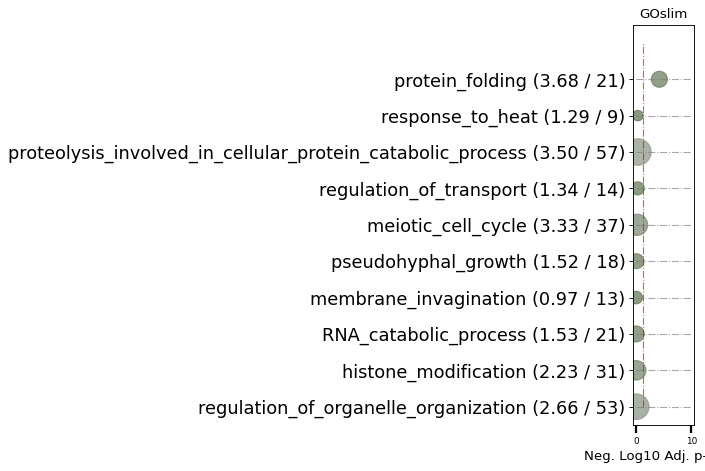

In [2]:
# Now we define the pattern not for KO1 but for KO2
# Find genes with specific flow patterns and perform pathway analysis
relFlow=fa.flow_finder(["?","?"],minLevels=[None,None,"neutral"],maxLevels=["down","down","neutral"],verbose=False)

# Pathway analysis using GOslim and additional gene sets
pw_file="./data/goslim.gmt"
pwScores = fa.analyse_pathways(use_edges=relFlow,genesets_file=pw_file)
pwScores_signif=pwScores.sort_values("pw_coverage_pval", ascending=True).head(20)
display(pwScores_signif)
fa.plotORAresult(pwScores_signif, "GOslim", numResults=10, figsize=(6,6), outfile="./plots/goslim_pathway_analysis")

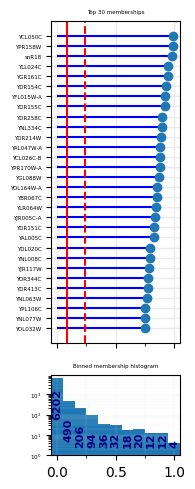

In [3]:
fa.plot_flow_memberships(use_edges=relFlow)
pattern_memberships = fa.calc_coarse_flow_memberships(use_edges=relFlow)

In [4]:
import numpy as np

pattern_memberships_pd = pattern_memberships.to_pandas()

high_membership = pattern_memberships_pd[pattern_memberships_pd['membership'] > 0.5]
display(high_membership)

,gene_id,membership
67,snR18,0.982868
79,snR35,0.627581
445,YAL005C,0.824098
498,YAL047W-A,0.881895
587,YBL022C,0.543202
...,...,...
6635,YPL032C,0.648335
6712,YPL106C,0.750238
6744,YPL136W,0.626336
7070,YPR158W,0.990313


In [5]:
import gseapy as gp #install via pip install gseapy

# ORA (Over-Representation Analysis)
ora_res = gp.enrichr(
    gene_list=high_membership['gene_id'].tolist(),
    gene_sets=pw_file,
    organism='Yeast',  # adjust if needed
    outdir=None,
    no_plot=True
)
display(ora_res.results.sort_values('Adjusted P-value', ascending=True).head(20))

# GSEA (Gene Set Enrichment Analysis)
# Prepare ranked list: gene_id to membership
rnk = pattern_memberships_pd
#rnk=high_membership
rnk = rnk.sort_values('membership', ascending=False).reset_index(drop=True)
gsea_res = gp.prerank(
    rnk=rnk ,
    gene_sets=pw_file,
    organism='Yeast',  # adjust if needed
    outdir=None,
    no_plot=False
)
display(gsea_res.res2d.sort_values('FWER p-val', ascending=True).head(20))

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
25,goslim.gmt,protein_folding,3/21,0.002635,0.105385,15.521081,92.179971,YDR214W;YDR258C;YAL005C
15,goslim.gmt,meiotic_cell_cycle,3/37,0.013413,0.268255,8.193043,35.324719,YDR207C;YDR446W;YDR155C
7,goslim.gmt,cellular_ion_homeostasis,1/29,0.342767,0.626382,3.686025,3.946646,YDR151C
0,goslim.gmt,DNA_recombination,1/36,0.407149,0.626382,2.938805,2.640744,YDR446W
9,goslim.gmt,chromosome_segregation,1/36,0.407149,0.626382,2.938805,2.640744,YBL063W
10,goslim.gmt,conjugation,1/31,0.361798,0.626382,3.437535,3.494840,YCL027W
8,goslim.gmt,chromatin_organization,2/69,0.255585,0.626382,2.679012,3.654707,YCR082W;YDR155C
2,goslim.gmt,RNA_catabolic_process,1/21,0.261220,0.626382,5.164844,6.933255,YDR151C
13,goslim.gmt,histone_modification,2/31,0.068842,0.626382,6.368487,17.041707,YCR082W;YDR155C
27,goslim.gmt,protein_targeting,2/49,0.150443,0.626382,3.884990,7.358839,YDR258C;YAL005C


2025-12-11 13:13:39,472 [WARNING] Duplicated values found in preranked stats: 77.46% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,cellular_amino_acid_metabolic_process,0.885441,1.051316,0.064,1.0,0.999,5/52,6.96%,YDR207C;YAL012W;YDR421W;YAL013W;YDR037W
1,prerank,response_to_oxidative_stress,0.898237,1.049058,0.154,1.0,0.999,1/25,4.60%,YBR216C
2,prerank,sporulation,0.889972,1.048392,0.116,1.0,0.999,5/35,10.10%,YDR155C;YDR104C;YBL058W;YDR208W;YDR099W
51,prerank,response_to_starvation,0.837933,0.979082,0.646293,0.948956,1.0,11/24,16.31%,YBL078C;YBL058W;YDR170C;YDL149W;YDL126C;YBR097...
50,prerank,pseudohyphal_growth,0.846007,0.979157,0.611,0.966131,1.0,9/18,13.11%,YDR207C;YDL159W;YDR480W;YDL230W;YBR057C;YDR099...
49,prerank,DNA_repair,0.817818,0.979174,0.811,0.985134,1.0,10/71,16.10%,YDL020C;YAR007C;YDR381W;YDL105W;YDR224C;YDR159...
48,prerank,DNA_replication,0.829786,0.979731,0.695,0.997114,1.0,9/40,16.95%,YAR007C;YAL013W;YBR060C;YBR057C;YDR099W;YAL021...
47,prerank,response_to_osmotic_stress,0.845829,0.979964,0.608,1.0,1.0,3/17,15.42%,YBR260C;YCL032W;YDR420W
46,prerank,nuclear_transport,0.831709,0.980612,0.646,1.0,1.0,9/36,12.05%,YAL005C;YDR381W;YBR111W-A;YDR432W;YBL103C;YDR3...
44,prerank,lipid_metabolic_process,0.822855,0.981945,0.742,1.0,1.0,15/62,14.29%,YDR207C;YDR284C;YAL051W;YCL004W;YDR302W;YDR319...


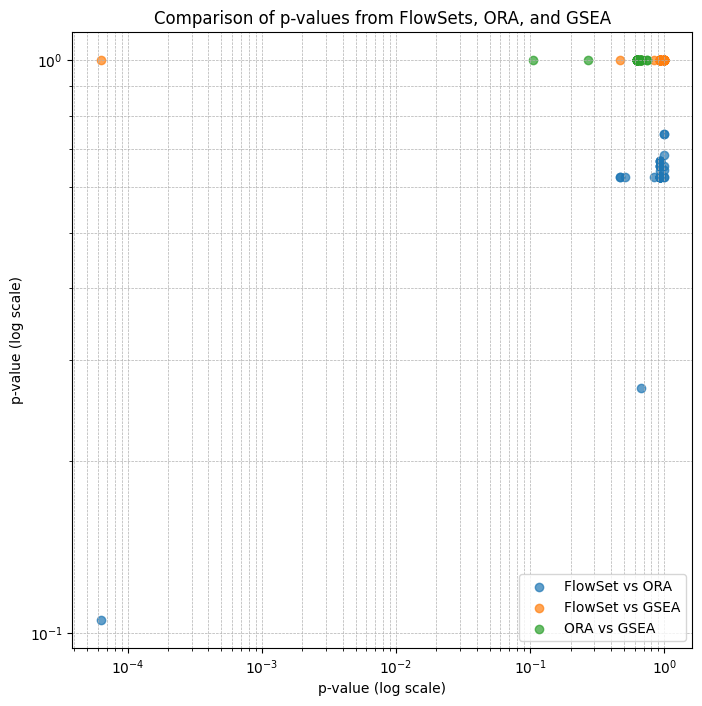

In [6]:
import matplotlib.pyplot as plt

# Extract p-values from each method
# 1. FlowSet pathway analysis (pwScores): 'pw_coverage_pval'
# 2. Enrichr ORA (ora_res): 'Adjusted P-value'
# 3. GSEA prerank (gsea_res): 'FWER p-val'

# Prepare DataFrames for merging
pw_df = pwScores[['pwid', 'pw_coverage_adj_pval']].rename(columns={'pwid': 'pwname', 'pw_coverage_adj_pval': 'FlowSet_pval'})
ora_df = ora_res.results[['Term', 'Adjusted P-value']].rename(columns={'Term': 'pwname', 'Adjusted P-value': 'ORA_pval'})
gsea_df = gsea_res.res2d[['Term', 'FWER p-val']].rename(columns={'Term': 'pwname', 'FWER p-val': 'GSEA_pval'})

# Merge on pathway name
merged = pw_df.merge(ora_df, on='pwname', how='outer').merge(gsea_df, on='pwname', how='outer')

# Drop rows with all NaNs
merged = merged.dropna(subset=['FlowSet_pval', 'ORA_pval', 'GSEA_pval'], how='all')

# Plot pairwise scatter plots
plt.figure(figsize=(8,8))
plt.scatter(merged['FlowSet_pval'], merged['ORA_pval'], label='FlowSet vs ORA', alpha=0.7)
plt.scatter(merged['FlowSet_pval'], merged['GSEA_pval'], label='FlowSet vs GSEA', alpha=0.7)
plt.scatter(merged['ORA_pval'], merged['GSEA_pval'], label='ORA vs GSEA', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('p-value (log scale)')
plt.ylabel('p-value (log scale)')
plt.legend()
plt.title('Comparison of p-values from FlowSets, ORA, and GSEA')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

As most of the memberships of the pattern are zero the fuzzy geneset overrepresentation method behaves in this example like ORA. 
In other examples with all features belonging partially to the pattern, it resembles a ranked approach.
It can be seen that especially for small feature sets the GSEA is not a universal solution.